# Alignment process for Stavangar recordings
This notebook describes the processes and results of the tapping and clapping synchronisation protocal to bring accelerometer measurements from dataloggers in Equivitals and AX3s into alignment.

The actual alignment code is in cue finding notebooks while the work of adjusting measurements to a shared concert time is performed and logged in "Into_Concert_time".


In [208]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport eq
%aimport qex
%aimport al

# Loading relevant concert time data

In [5]:
Piece_timings = pd.read_csv('./Timing/ctimes.csv')
Piece_timings.iloc[:5,:] 

,Event,RD,C1,C2,C3,C4,C5
0,Pre-Audio,NaN,NaN,-421.378,NaN,NaN,-981.902
1,Warmup,-300.000,-348.482,-361.303,-52.946,-344.999,-386.462
2,Tuning,-58.745,-61.511,-49.122,-48.773,-48.983,-225.636
3,Synch Taps,0.000,0.000,0.000,0.000,0.000,0.000
4,Applause for Conductor,19.294,28.292,122.014,76.074,21.929,-30.137


In [12]:
Piece_dt = pd.read_csv('./Timing/ConcertDateTimes.csv',index_col = 0)
for c in Piece_dt.columns[3:]:
    Piece_dt.loc[:,c] = pd.to_datetime(Piece_dt.loc[:,c]).dt.tz_convert('UTC')
Piece_dt.loc[:5,:]

,Related,Event_Type,Event,RD,C1,C2,C3,C4,C5
0,Init,Stage,Pre-Audio,NaT,NaT,2023-02-16 10:09:21.319000+00:00,NaT,NaT,2023-02-18 14:54:07.681000+00:00
1,Init,Orch,Warmup,2023-02-15 11:00:36.897000+00:00,2023-02-16 08:27:30.042000+00:00,2023-02-16 10:10:21.394000+00:00,2023-02-17 08:29:58.895000+00:00,2023-02-17 10:10:41.889000+00:00,2023-02-18 15:04:03.121000+00:00
2,Init,Orch,Tuning,2023-02-15 11:04:38.152000+00:00,2023-02-16 08:32:17.013000+00:00,2023-02-16 10:15:33.575000+00:00,2023-02-17 08:30:03.068000+00:00,2023-02-17 10:15:37.905000+00:00,2023-02-18 15:06:43.947000+00:00
3,Init,Orch,Synch Taps,2023-02-15 11:05:36.897000+00:00,2023-02-16 08:33:18.524000+00:00,2023-02-16 10:16:22.697000+00:00,2023-02-17 08:30:51.841000+00:00,2023-02-17 10:16:26.888000+00:00,2023-02-18 15:10:29.583000+00:00
4,Init,Applause,Applause for Conductor,2023-02-15 11:05:56.191000+00:00,2023-02-16 08:33:46.816000+00:00,2023-02-16 10:18:24.711000+00:00,2023-02-17 08:32:07.915000+00:00,2023-02-17 10:16:48.817000+00:00,2023-02-18 15:09:59.446000+00:00
5,Saev,Music,Saevarud,2023-02-15 11:06:20.804000+00:00,2023-02-16 08:34:03.424000+00:00,2023-02-16 11:11:01.919000+00:00,2023-02-17 09:25:39.887000+00:00,2023-02-17 10:16:57.035000+00:00,2023-02-18 15:10:44.919000+00:00


## gather data logs


In [248]:
cutlogs_eq = pd.read_csv('./out_data/EQIVITALS_CUTLOGS.csv')
cutlogs_ax3 = pd.read_csv('./out_data/AX3_CUTLOGS.csv')

In [249]:
cutlogs_eq.columns

Index(['Unnamed: 0', 'PartID', 'Day', 'DevID', 'Cue0_code', 'Cue0_ddt',
       'Cue0_rdt', 'Cue0_rst', 'Cue0_shift', 'Cue1_code', 'Cue1_ddt',
       'Cue1_shift', 'Scaling_C', 'Source_filename', 'Output_files'],
      dtype='object')

In [250]:
devs = cutlogs_ax3['DevID'].unique()

In [254]:
#pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='Participant',data=mm_df)
pg.rm_anova(dv='Scaling_C',within = 'Day',subject='DevID',data=cutlogs_eq)

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,Day,3,135,49.568673,1.150774e-21,0.092153,0.823338


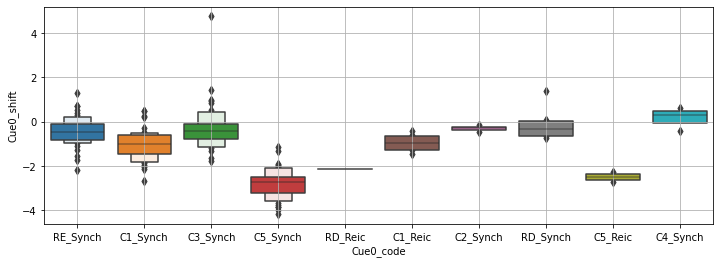

In [282]:
tag_Q = 'Cue0_code'
tag_m = 'Cue0_shift'
f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
sns.boxenplot(x = 'Cue0_code',y = tag_m, data = cutlogs_eq, ax = ax1,order = [])
plt.grid()
plt.show()

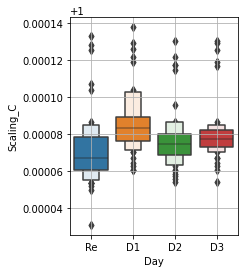

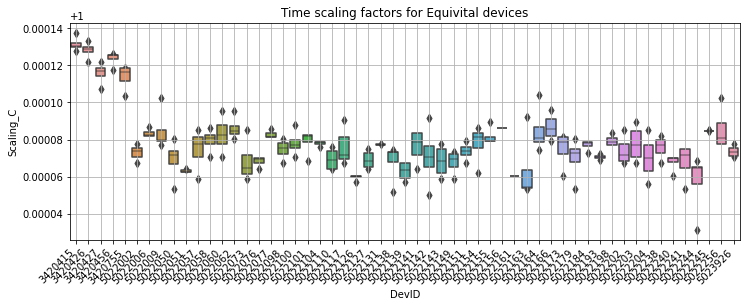

In [305]:
tag_m = 'Scaling_C' # Cue1_shift
f, (ax1) = plt.subplots(1, 1,figsize=(3,4))
#response_order = ['Hall','Virtual']
sns.boxenplot(x = 'Day',y = 'Scaling_C',data = cutlogs_eq, ax = ax1)
plt.grid()
plt.show()
f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
sns.boxenplot(x = 'DevID',y ='Scaling_C',data = cutlogs_eq, ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45,ha='right')#plt.set_xticklabels(rotation=45)
plt.title('Time scaling factors for Equivital devices')
plt.grid()
plt.savefig('./plots/TimeScaling_Equivitals.png',bbox_inches = 'tight',dpi = 300)
plt.show()

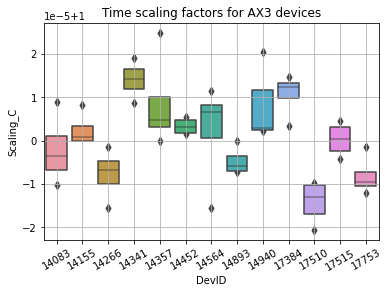

In [306]:
ax = sns.boxenplot(x ='DevID',y = 'Scaling_C',data = cutlogs_ax3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)#plt.set_xticklabels(rotation=45)
plt.title('Time scaling factors for AX3 devices')
plt.grid()
plt.savefig('./plots/TimeScaling_AX3s.png',bbox_inches = 'tight',dpi = 300)
plt.show()

In [266]:
cutlogs = cutlogs_ax3 #.loc[~(cutlogs_eq['Day']=='D3'),:].copy()

# Assessing scaling per device

In [72]:
synch_times = {'RE_Synch':pd.to_datetime('2023-02-15 10:25:26.573+0000'),
               'RD_Synch':pd.to_datetime('2023-02-15 11:05:36.897+0000'),
               'RD_Reic': pd.to_datetime('2023-02-15 11:16:50.919+0000'),
               'RD_Reic2':pd.to_datetime('2023-02-15 12:02:00.040+0000'),# -2.46
              'C1_Synch':pd.to_datetime('2023-02-16 8:33:18.524+0000'), # +0.2
               'C1_Reic':pd.to_datetime('2023-02-16 08:45:22.446+0000'),# +0.2
               'C2_Synch':pd.to_datetime('2023-02-16 10:16:22.697+0000'),
               'C2_Reic':pd.to_datetime('2023-02-16 10:27:10.927+0000'),
              'C3_Synch':pd.to_datetime('2023-02-17 08:30:51.841000+00:00'),
               'C3_Reic':pd.to_datetime('2023-02-17 08:40:31.007000+00:00'),
               'C4_Synch': pd.to_datetime('2023-02-17 10:16:26.888000+00:00'),#'C4_Synch': pd.to_datetime('2023-02-17 10:16:29.298000+00:00'),
               'C4_Reic':pd.to_datetime('2023-02-17 10:27:20.769000+00:00'),#'C4_Reic':pd.to_datetime('2023-02-17 10:27:23.179000+00:00'),
              'C5_Synch':pd.to_datetime('2023-02-18 15:10:29.583000+00:00'),
               'C5_Reic':pd.to_datetime('2023-02-18 15:22:04.555000+00:00')}

In [73]:
cue_time_map = pd.DataFrame(index = cues_aligned.columns,columns = ['dt_UTC','cTime_s','rTime_s'])
cue_time_map['dt_UTC'] = pd.Series(synch_times)
rec_days = {'Re':['RE_Synch', 'RD_Synch', 'RD_Reic','RD_Reic2'], #, 'RD_Reic2'
            'D1':['C1_Synch', 'C1_Reic','C2_Synch', 'C2_Reic'],
           'D2':['C3_Synch', 'C3_Reic', 'C4_Synch', 'C4_Reic'],
            'D3':['C5_Synch', 'C5_Reic']}
sync_days = {'Re':'RE_Synch',
            'D1':'C1_Synch',
            'D2':'C3_Synch',
            'D3':'C5_Synch'}
rec_con = {'RE':['RE_Synch'],
           'RD':['RD_Synch', 'RD_Reic','RD_Reic2'],#, 'RD_Reic2'
           'C1':['C1_Synch', 'C1_Reic'],
           'C2':['C2_Synch', 'C2_Reic'],
           'C3':['C3_Synch', 'C3_Reic'],
           'C4':[ 'C4_Synch', 'C4_Reic'],
           'C5':['C5_Synch', 'C5_Reic']}
sync_con = {'RG':'RE_Synch',
            'RE':'RE_Synch',
            'RD':'RD_Synch',
            'C1':'C1_Synch',
            'C2':'C2_Synch', 
            'C3':'C3_Synch',
            'C4':'C4_Synch',
            'C5':'C5_Synch'}

for s in rec_days.keys():
    cue_time_map.loc[rec_days[s],'rTime_s'] = (cue_time_map.loc[rec_days[s],'dt_UTC']-cue_time_map.loc[sync_days[s],'dt_UTC']).dt.total_seconds()
for s in rec_con.keys():
    cue_time_map.loc[rec_con[s],'cTime_s'] = (cue_time_map.loc[rec_con[s],'dt_UTC']-cue_time_map.loc[sync_con[s],'dt_UTC']).dt.total_seconds()

#cue_time_map.loc[[],'cTime_s'] = 
cue_time_map.to_csv('./Timing/cue_times_mapping.csv')
cue_time_map

,dt_UTC,cTime_s,rTime_s
RE_Synch,2023-02-15 10:25:26.573000+00:00,0.0,0.0
RD_Synch,2023-02-15 11:05:36.897000+00:00,0.0,2410.324
RD_Reic,2023-02-15 11:16:50.919000+00:00,674.022,3084.346
RD_Reic2,2023-02-15 12:02:00.040000+00:00,3383.143,5793.467
C1_Synch,2023-02-16 08:33:18.524000+00:00,0.0,0.0
C1_Reic,2023-02-16 08:45:22.446000+00:00,723.922,723.922
C2_Synch,2023-02-16 10:16:22.697000+00:00,0.0,6184.173
C2_Reic,2023-02-16 10:27:10.927000+00:00,648.23,6832.403
C3_Synch,2023-02-17 08:30:51.841000+00:00,0.0,0.0
C3_Reic,2023-02-17 08:40:31.007000+00:00,579.166,579.166


In [308]:
dev_scalings = pd.read_csv('Dev_scaling.csv')
dev_scalings

,Dev_ID,PartID,Scaling_C
0,3420426,VN102,1.000129
1,5022006,VN107,1.000082
2,5022002,VN106,1.000074
3,5022009,VN108,1.000080
4,3420415,VN101,1.000130
...,...,...,...
63,14083,VN104,0.999998
64,17515,VN105,1.000003
65,17384,VN106,1.000012
66,14940,VN107,1.000002


## AX3s 

In [319]:
cues_aligned = pd.read_csv('RE_RD_AX3s.csv', index_col = 0)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C1_C2_AX3s.csv', index_col = 0)],axis=1)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C3_C4_AX3s.csv', index_col = 0)],axis=1)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C5_AX3s.csv', index_col = 0)],axis=1)

for c in cues_aligned.columns:
    cues_aligned[c] = pd.to_datetime(cues_aligned[c])
print(len(cues_aligned))
cues_aligned.loc[:,rec_days['D1']]

13


,C1_Synch,C1_Reic,C2_Synch,C2_Reic
LS401,2023-02-16 08:33:21.924000+00:00,2023-02-16 08:45:25.856000+00:00,2023-02-16 10:16:26.057000+00:00,2023-02-16 10:27:14.287000+00:00
LS405,NaT,2023-02-16 08:45:25.956000+00:00,2023-02-16 10:16:26.227000+00:00,2023-02-16 10:27:14.497000+00:00
LS406,2023-02-16 08:33:21.944000+00:00,2023-02-16 08:45:25.806000+00:00,2023-02-16 10:16:26.087000+00:00,2023-02-16 10:27:14.217000+00:00
LS407,2023-02-16 08:33:21.964000+00:00,2023-02-16 08:45:25.896000+00:00,2023-02-16 10:16:26.187000+00:00,2023-02-16 10:27:14.367000+00:00
LS408,2023-02-16 08:33:22.044000+00:00,2023-02-16 08:45:25.916000+00:00,2023-02-16 10:16:26.227000+00:00,2023-02-16 10:27:14.457000+00:00
VN101,NaT,2023-02-16 08:45:25.886000+00:00,2023-02-16 10:16:26.137000+00:00,2023-02-16 10:27:14.317000+00:00
VN102,2023-02-16 08:33:22.044000+00:00,2023-02-16 08:45:25.916000+00:00,2023-02-16 10:16:26.237000+00:00,2023-02-16 10:27:14.457000+00:00
VN103,2023-02-16 08:33:21.944000+00:00,2023-02-16 08:45:25.896000+00:00,2023-02-16 10:16:26.047000+00:00,2023-02-16 10:27:14.317000+00:00
VN104,2023-02-16 08:33:22.084000+00:00,2023-02-16 08:45:25.946000+00:00,2023-02-16 10:16:26.187000+00:00,2023-02-16 10:27:14.427000+00:00
VN105,2023-02-16 08:33:22.004000+00:00,2023-02-16 08:45:25.906000+00:00,2023-02-16 10:16:26.137000+00:00,2023-02-16 10:27:14.377000+00:00


In [320]:
Shiftings = pd.DataFrame(index = cues_aligned.index,columns = cues_aligned.columns)
for cue in cues_aligned.columns:
    Shiftings.loc[:,cue] = (cues_aligned[cue] - synch_times[cue]).dt.total_seconds()
Shiftings.std()

RE_Synch    0.064994
RD_Synch    0.066805
RD_Reic     0.079639
RD_Reic2    0.102791
C1_Synch    0.057667
C1_Reic     0.043041
C2_Synch    0.074239
C2_Reic     0.090014
C3_Synch    0.052023
C3_Reic     0.050026
C4_Synch    0.074893
C4_Reic     0.091617
C5_Synch    0.415160
C5_Reic     0.411623
dtype: float64

In [321]:
Shiftings.std().mean()

0.11960935369368517

In [330]:
#scaling
Shifteds = pd.DataFrame(index = cues_aligned.index,columns = cues_aligned.columns)
for part in cues_aligned.index:
    for rec_day in rec_days.keys():
        refs = rec_days[rec_day]
        G = cues_aligned.loc[part,refs].copy()
        subrefs = list(G.loc[~pd.isnull(G)].index)
        if subrefs:
            if len(subrefs)==1:
                sref = subrefs[0]
                SC = dev_scalings.loc[dev_scalings['PartID']==part,'Scaling_C'].values[0] #1 # define from average after? or other intervals form that sensor?
            else:
                sref = subrefs[0]
                eref = subrefs[-1]
                if (cue_time_map.loc[eref,'dt_UTC']-cue_time_map.loc[sref,'dt_UTC']).total_seconds()>3600:
                    SC = ((cue_time_map.loc[eref,'dt_UTC']-cue_time_map.loc[sref,'dt_UTC']).total_seconds()
                                   /(cues_aligned.loc[part,eref]-cues_aligned.loc[part,sref]).total_seconds())
                else:
                    SC = dev_scalings.loc[dev_scalings['PartID']==part,'Scaling_C'].values[0] #1 # define from average after? or other intervals form that sensor?

            Shifteds.loc[part,subrefs] = ((G[subrefs] - G[sref]).dt.total_seconds()*SC + cue_time_map.loc[sref,'rTime_s']) - cue_time_map.loc[subrefs,'rTime_s']
            

print(np.round(Shifteds[['RD_Synch', 'RD_Reic','C1_Reic',
       'C2_Synch', 'C3_Reic', 'C4_Synch', 'C5_Reic']].std().mean(),3))            
Shifteds.std()

0.036


RE_Synch    0.000000e+00
RD_Synch    4.057865e-02
RD_Reic     2.859241e-02
RD_Reic2    4.683249e-13
C1_Synch    0.000000e+00
C1_Reic     3.785262e-02
C2_Synch    4.140796e-02
C2_Reic     8.615925e-13
C3_Synch    0.000000e+00
C3_Reic     2.990317e-02
C4_Synch    3.663480e-02
C4_Reic     4.605405e-13
C5_Synch    0.000000e+00
C5_Reic     3.776486e-02
dtype: float64

In [333]:
# no scaling
Shifteds = pd.DataFrame(index = cues_aligned.index,columns = cues_aligned.columns)
for part in cues_aligned.index:
    for rec_day in rec_days.keys():
        refs = rec_days[rec_day]
        G = cues_aligned.loc[part,refs].copy()
        subrefs = list(G.loc[~pd.isnull(G)].index)
        if subrefs:
            sref = subrefs[0]
            Shifteds.loc[part,subrefs] = ((G[subrefs] - G[sref]).dt.total_seconds() + cue_time_map.loc[sref,'rTime_s']) - cue_time_map.loc[subrefs,'rTime_s']

print(np.round(Shifteds[['RD_Synch', 'RD_Reic','C1_Reic',
       'C2_Synch', 'C3_Reic', 'C4_Synch', 'C5_Reic']].std().mean(),3))
print(np.round(Shifteds[['RD_Synch', 'RD_Reic','RD_Reic2','C1_Reic',
       'C2_Synch','C2_Reic','C3_Reic', 'C4_Synch','C4_Reic', 'C5_Reic']].std().mean(),3))             
Shifteds.std()

0.042
0.048


RE_Synch    0.000000
RD_Synch    0.039109
RD_Reic     0.048336
RD_Reic2    0.059766
C1_Synch    0.000000
C1_Reic     0.042001
C2_Synch    0.044814
C2_Reic     0.067187
C3_Synch    0.000000
C3_Reic     0.033069
C4_Synch    0.051216
C4_Reic     0.062961
C5_Synch    0.000000
C5_Reic     0.033282
dtype: float64

In [334]:
#scaling per device mean
Shifteds = pd.DataFrame(index = cues_aligned.index,columns = cues_aligned.columns)
for part in cues_aligned.index:
    for rec_day in rec_days.keys():
        refs = rec_days[rec_day]
        G = cues_aligned.loc[part,refs].copy()
        subrefs = list(G.loc[~pd.isnull(G)].index)
        if subrefs:
            sref = subrefs[0]
            SC = dev_scalings.loc[dev_scalings['PartID']==part,'Scaling_C'].values[0] #1 # define from average after? or other intervals form that sensor?
            Shifteds.loc[part,subrefs] = ((G[subrefs] - G[sref]).dt.total_seconds()*SC + cue_time_map.loc[sref,'rTime_s']) - cue_time_map.loc[subrefs,'rTime_s']
            
print(np.round(Shifteds[['RD_Synch', 'RD_Reic','C1_Reic',
       'C2_Synch', 'C3_Reic', 'C4_Synch', 'C5_Reic']].std().mean(),3))
print(np.round(Shifteds[['RD_Synch', 'RD_Reic','RD_Reic2','C1_Reic',
       'C2_Synch','C2_Reic','C3_Reic', 'C4_Synch','C4_Reic', 'C5_Reic']].std().mean(),3))  
Shifteds.std()

0.091
0.118


RE_Synch    0.000000
RD_Synch    0.084160
RD_Reic     0.092173
RD_Reic2    0.149934
C1_Synch    0.000000
C1_Reic     0.044988
C2_Synch    0.152280
C2_Reic     0.184261
C3_Synch    0.000000
C3_Reic     0.043966
C4_Synch    0.184790
C4_Reic     0.201524
C5_Synch    0.000000
C5_Reic     0.037765
dtype: float64

In [188]:
Scalings.keys()

dict_keys(['RE_Synch RD_Synch', 'RE_Synch RD_Reic', 'RE_Synch RD_Reic2', 'RD_Synch RD_Reic', 'RD_Synch RD_Reic2', 'RD_Reic RD_Reic2', 'C1_Synch C1_Reic', 'C1_Synch C2_Synch', 'C1_Synch C2_Reic', 'C1_Reic C2_Synch', 'C1_Reic C2_Reic', 'C2_Synch C2_Reic', 'C3_Synch C3_Reic', 'C3_Synch C4_Synch', 'C3_Synch C4_Reic', 'C3_Reic C4_Synch', 'C3_Reic C4_Reic', 'C4_Synch C4_Reic'])

In [190]:
# scaling test
cue_aligned = cues_aligned.copy()
df_scales = pd.DataFrame(index = cue_aligned.index,columns = ['C1_Synch C1_Reic', 'C1_Synch C2_Synch', 'C1_Synch C2_Reic', 'C1_Reic C2_Synch', 'C1_Reic C2_Reic', 'C2_Synch C2_Reic','C3_Synch C3_Reic', 'C3_Synch C4_Synch', 'C3_Synch C4_Reic', 'C3_Reic C4_Synch', 'C3_Reic C4_Reic', 'C4_Synch C4_Reic'])

for pid in cues_aligned.index:
    Scalings = {}
    for j in range(len(rec_days['D1'])):
        cue1 = rec_days['D1'][j]
        for k in range(j+1,len(rec_days['D1'])):
            cue2 = rec_days['D1'][k]
            Scalings[cue1+' '+cue2] = (synch_times[cue2]-synch_times[cue1]).total_seconds()/(cue_aligned.loc[pid,cue2]-cue_aligned.loc[pid,cue1]).total_seconds()
    for j in range(len(rec_days['D2'])):
        cue1 = rec_days['D2'][j]
        for k in range(j+1,len(rec_days['D2'])):
            cue2 = rec_days['D2'][k]
            Scalings[cue1+' '+cue2] = (synch_times[cue2]-synch_times[cue1]).total_seconds()/(cue_aligned.loc[pid,cue2]-cue_aligned.loc[pid,cue1]).total_seconds()

            
    df_scales.loc[pid,:] = Scalings
    
df_scales   

,C1_Synch C1_Reic,C1_Synch C2_Synch,C1_Synch C2_Reic,C1_Reic C2_Synch,C1_Reic C2_Reic,C2_Synch C2_Reic,C3_Synch C3_Reic,C3_Synch C4_Synch,C3_Synch C4_Reic,C3_Reic C4_Synch,C3_Reic C4_Reic,C4_Synch C4_Reic
LS401,0.999986,1.000006,1.000006,1.000009,1.000008,1.0,1.000052,1.000002,1.000011,0.999997,1.000008,1.000107
LS405,NaN,NaN,NaN,0.999996,0.99999,0.999938,0.999948,0.999989,0.999984,0.999993,0.999988,0.999939
LS406,1.000083,1.000005,1.000019,0.999995,1.000011,1.000154,1.000086,1.000011,1.000013,1.000003,1.000006,1.000031
LS407,0.999986,0.999992,1.0,0.999993,1.000002,1.000077,0.999948,0.999994,0.999993,0.999998,0.999997,0.999985
LS408,1.000069,0.999998,0.999999,0.999989,0.99999,1.0,1.000069,0.999994,0.999994,0.999986,0.999988,1.0
VN101,NaN,NaN,NaN,1.0,1.000008,1.000077,0.999914,0.999992,1.0,1.0,1.000008,1.000076
VN102,1.000069,0.999997,0.999999,0.999987,0.99999,1.000015,0.999948,0.999987,0.99999,0.999991,0.999994,1.000015
VN103,0.999959,1.000011,1.000004,1.000018,1.00001,0.999938,0.999948,0.999994,1.000001,0.999998,1.000006,1.000076
VN104,1.000083,1.000011,1.000009,1.000002,1.0,0.999985,0.999965,0.999987,0.999994,0.99999,0.999997,1.000061
VN105,1.000028,1.000006,1.000004,1.000004,1.000002,0.999985,0.999948,1.000002,0.999996,1.000007,1.0,0.999939


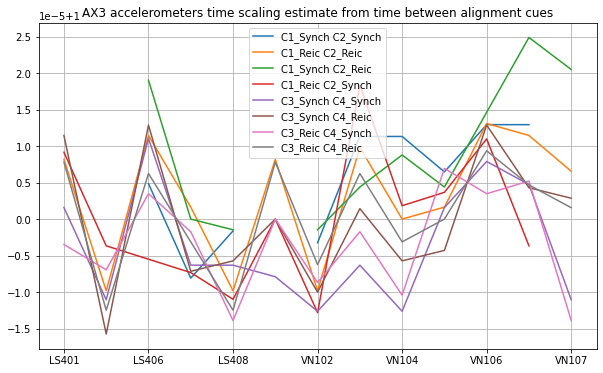

In [195]:
f, (ax) = plt.subplots(1, 1,figsize=(10,6))
longer_diffs = ['C1_Synch C2_Synch','C1_Reic C2_Reic','C1_Synch C2_Reic', 'C1_Reic C2_Synch','C3_Synch C4_Synch', 'C3_Synch C4_Reic', 'C3_Reic C4_Synch', 'C3_Reic C4_Reic',]

df_scales[longer_diffs].plot(ax=ax)
plt.grid()
plt.title('AX3 accelerometers time scaling estimate from time between alignment cues')
plt.savefig('./plots/AX_scalingC_LongerD1D2.png', bbox_inches = 'tight',dpi = 300)
plt.show()

In [196]:

df_scales[longer_diffs].median(axis=1).to_csv('AX3_scaling_default.csv')
df_scales[longer_diffs].std(axis=1)

LS401    0.000005
LS405    0.000004
LS406    0.000007
LS407    0.000004
LS408    0.000005
VN101    0.000006
VN102    0.000004
VN103    0.000008
VN104    0.000009
VN105    0.000004
VN106    0.000004
VN108    0.000008
VN107    0.000013
dtype: float64

## Equivitals

In [335]:
cues_aligned = pd.read_csv('RE_RD_Equivitals.csv', index_col = 0)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C1_C2_Equivitals.csv', index_col = 0)],axis=1)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C3_C4_Equivitals.csv', index_col = 0)],axis=1)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C5_Equivitals.csv', index_col = 0)],axis=1)

for c in cues_aligned.columns:
    cues_aligned[c] = pd.to_datetime(cues_aligned[c])
print(len(cues_aligned))
cues_aligned.loc[:,rec_days['Re']]
player_order = cues_aligned.index

55


In [336]:
Shiftings = pd.DataFrame(index = cues_aligned.index,columns = cues_aligned.columns)
for cue in cue_aligned.columns:
    Shiftings.loc[:,cue] = (cues_aligned[cue] - synch_times[cue]).dt.total_seconds()
Shiftings.std()

RE_Synch    0.650497
RD_Synch    0.677738
RD_Reic     0.715705
RD_Reic2    0.705147
C1_Synch    0.684505
C1_Reic     0.637643
C2_Synch    0.668884
C2_Reic     0.656955
C3_Synch    1.002695
C3_Reic     1.005835
C4_Synch    1.013769
C4_Reic     1.036154
C5_Synch    0.662655
C5_Reic     0.645893
dtype: float64

In [304]:
Shiftings.std().mean()

0.7688625070520196

In [337]:
#No scaleing
Shifteds = pd.DataFrame(index = cues_aligned.index,columns = cues_aligned.columns)
for part in cues_aligned.index:
    for rec_day in rec_days.keys():
        refs = rec_days[rec_day]
        G = cues_aligned.loc[part,refs].copy()
        subrefs = list(G.loc[~pd.isnull(G)].index)
        if subrefs:
            sref = subrefs[0]
            Shifteds.loc[part,subrefs] = ((G[subrefs] - G[sref]).dt.total_seconds() + cue_time_map.loc[sref,'rTime_s']) - cue_time_map.loc[subrefs,'rTime_s']
            
print(np.round(Shifteds[['RD_Synch', 'RD_Reic','C1_Reic',
       'C2_Synch', 'C3_Reic', 'C4_Synch', 'C5_Reic']].std().mean(),3))
print(np.round(Shifteds[['RD_Synch', 'RD_Reic','RD_Reic2','C1_Reic',
       'C2_Synch','C2_Reic','C3_Reic', 'C4_Synch','C4_Reic', 'C5_Reic']].std().mean(),3))  
Shifteds.std()

0.09
0.104


RE_Synch    0.000000
RD_Synch    0.084882
RD_Reic     0.094208
RD_Reic2    0.119557
C1_Synch    0.000000
C1_Reic     0.058142
C2_Synch    0.143701
C2_Reic     0.150714
C3_Synch    0.000000
C3_Reic     0.047657
C4_Synch    0.158998
C4_Reic     0.137756
C5_Synch    0.000000
C5_Reic     0.042141
dtype: float64

In [338]:
#scaling per device mean
Shifteds = pd.DataFrame(index = cues_aligned.index,columns = cues_aligned.columns)
for part in cues_aligned.index:
    for rec_day in rec_days.keys():
        refs = rec_days[rec_day]
        G = cues_aligned.loc[part,refs].copy()
        subrefs = list(G.loc[~pd.isnull(G)].index)
        if subrefs:
            sref = subrefs[0]
            SC = dev_scalings.loc[dev_scalings['PartID']==part,'Scaling_C'].values[0] #1 # define from average after? or other intervals form that sensor?
            Shifteds.loc[part,subrefs] = ((G[subrefs] - G[sref]).dt.total_seconds()*SC + cue_time_map.loc[sref,'rTime_s']) - cue_time_map.loc[subrefs,'rTime_s']
            
print(np.round(Shifteds[['RD_Synch', 'RD_Reic','C1_Reic',
       'C2_Synch', 'C3_Reic', 'C4_Synch', 'C5_Reic']].std().mean(),3))
print(np.round(Shifteds[['RD_Synch', 'RD_Reic','RD_Reic2','C1_Reic',
       'C2_Synch','C2_Reic','C3_Reic', 'C4_Synch','C4_Reic', 'C5_Reic']].std().mean(),3))  
Shifteds.std()

0.049
0.049


RE_Synch    0.000000
RD_Synch    0.041758
RD_Reic     0.053798
RD_Reic2    0.057045
C1_Synch    0.000000
C1_Reic     0.051048
C2_Synch    0.058236
C2_Reic     0.048298
C3_Synch    0.000000
C3_Reic     0.046534
C4_Synch    0.047452
C4_Reic     0.039996
C5_Synch    0.000000
C5_Reic     0.043321
dtype: float64

In [339]:
#scaling with recording 
Shifteds = pd.DataFrame(index = cues_aligned.index,columns = cues_aligned.columns)
for part in cues_aligned.index:
    for rec_day in rec_days.keys():
        refs = rec_days[rec_day]
        G = cues_aligned.loc[part,refs].copy()
        subrefs = list(G.loc[~pd.isnull(G)].index)
        if subrefs:
            if len(subrefs)==1:
                sref = subrefs[0]
                SC = dev_scalings.loc[dev_scalings['PartID']==part,'Scaling_C'].values[0] #1 # define from average after? or other intervals form that sensor?
            else:
                sref = subrefs[0]
                eref = subrefs[-1]
                if (cue_time_map.loc[eref,'dt_UTC']-cue_time_map.loc[sref,'dt_UTC']).total_seconds()>3600:
                    SC = ((cue_time_map.loc[eref,'dt_UTC']-cue_time_map.loc[sref,'dt_UTC']).total_seconds()
                                   /(cues_aligned.loc[part,eref]-cues_aligned.loc[part,sref]).total_seconds())
                else:
                    SC = dev_scalings.loc[dev_scalings['PartID']==part,'Scaling_C'].values[0] #1 # define from average after? or other intervals form that sensor?

            Shifteds.loc[part,subrefs] = ((G[subrefs] - G[sref]).dt.total_seconds()*SC + cue_time_map.loc[sref,'rTime_s']) - cue_time_map.loc[subrefs,'rTime_s']
            

print(np.round(Shifteds[['RD_Synch', 'RD_Reic','C1_Reic',
       'C2_Synch', 'C3_Reic', 'C4_Synch', 'C5_Reic']].std().mean(),3))            
Shifteds.std()

0.044


RE_Synch    0.000000
RD_Synch    0.040631
RD_Reic     0.045876
RD_Reic2    0.038243
C1_Synch    0.000000
C1_Reic     0.047160
C2_Synch    0.046517
C2_Reic     0.004390
C3_Synch    0.000000
C3_Reic     0.044394
C4_Synch    0.042550
C4_Reic     0.003121
C5_Synch    0.000000
C5_Reic     0.043321
dtype: float64

In [198]:
longer_diffs = ['RE_Synch RD_Synch', 'RE_Synch RD_Reic', 'RE_Synch RD_Reic2','RD_Synch RD_Reic2', 'RD_Reic RD_Reic2','C1_Synch C2_Synch','C1_Reic C2_Reic','C1_Synch C2_Reic', 'C1_Reic C2_Synch','C3_Synch C4_Synch', 'C3_Synch C4_Reic', 'C3_Reic C4_Synch', 'C3_Reic C4_Reic',]


In [200]:
# scaling test
cue_aligned = cues_aligned.copy()
all_diffs = ['RE_Synch RD_Synch', 'RE_Synch RD_Reic', 'RE_Synch RD_Reic2', 'RD_Synch RD_Reic', 'RD_Synch RD_Reic2', 'RD_Reic RD_Reic2', 'C1_Synch C1_Reic', 'C1_Synch C2_Synch', 'C1_Synch C2_Reic', 'C1_Reic C2_Synch', 'C1_Reic C2_Reic', 'C2_Synch C2_Reic', 'C3_Synch C3_Reic', 'C3_Synch C4_Synch', 'C3_Synch C4_Reic', 'C3_Reic C4_Synch', 'C3_Reic C4_Reic', 'C4_Synch C4_Reic']
df_scales = pd.DataFrame(index = cue_aligned.index,columns = all_diffs)

for pid in cues_aligned.index:
    Scalings = {}
    for j in range(len(rec_days['Re'])):
        cue1 = rec_days['Re'][j]
        for k in range(j+1,len(rec_days['Re'])):
            cue2 = rec_days['Re'][k]
            Scalings[cue1+' '+cue2] = (synch_times[cue2]-synch_times[cue1]).total_seconds()/(cue_aligned.loc[pid,cue2]-cue_aligned.loc[pid,cue1]).total_seconds()

    for j in range(len(rec_days['D1'])):
        cue1 = rec_days['D1'][j]
        for k in range(j+1,len(rec_days['D1'])):
            cue2 = rec_days['D1'][k]
            Scalings[cue1+' '+cue2] = (synch_times[cue2]-synch_times[cue1]).total_seconds()/(cue_aligned.loc[pid,cue2]-cue_aligned.loc[pid,cue1]).total_seconds()
    for j in range(len(rec_days['D2'])):
        cue1 = rec_days['D2'][j]
        for k in range(j+1,len(rec_days['D2'])):
            cue2 = rec_days['D2'][k]
            Scalings[cue1+' '+cue2] = (synch_times[cue2]-synch_times[cue1]).total_seconds()/(cue_aligned.loc[pid,cue2]-cue_aligned.loc[pid,cue1]).total_seconds()
            
    df_scales.loc[pid,:] = Scalings
    
df_scales 

,RE_Synch RD_Synch,RE_Synch RD_Reic,RE_Synch RD_Reic2,RD_Synch RD_Reic,RD_Synch RD_Reic2,RD_Reic RD_Reic2,C1_Synch C1_Reic,C1_Synch C2_Synch,C1_Synch C2_Reic,C1_Reic C2_Synch,C1_Reic C2_Reic,C2_Synch C2_Reic,C3_Synch C3_Reic,C3_Synch C4_Synch,C3_Synch C4_Reic,C3_Reic C4_Synch,C3_Reic C4_Reic,C4_Synch C4_Reic
VN102,1.000133,1.00012,1.000133,1.000074,1.000133,1.000148,1.000235,1.000129,1.000129,1.000115,1.000116,1.000123,1.000052,1.000126,1.000122,1.000134,1.000128,1.000076
VN107,NaN,NaN,NaN,NaN,NaN,1.000144,NaN,NaN,NaN,NaN,1.000087,NaN,1.000104,1.000073,1.000083,1.000069,1.000081,1.000184
VN106,1.000066,1.000062,1.000067,1.000045,1.000068,1.000074,1.000069,1.000074,1.000078,1.000075,1.000079,1.000108,NaN,NaN,NaN,NaN,NaN,NaN
VN108,1.000083,1.000042,NaN,0.999896,NaN,NaN,1.000276,1.0001,1.000102,1.000077,1.000082,1.000123,0.999983,1.000068,1.000077,1.000076,1.000086,1.000168
VN101,1.000145,NaN,1.000128,NaN,1.000115,NaN,NaN,NaN,NaN,1.000114,1.000138,1.00034,1.000017,1.000123,1.00013,1.000134,1.00014,1.000199
VN105,1.000091,1.000075,1.000104,1.000015,1.000112,1.000137,1.000055,1.000121,1.000119,1.00013,1.000126,1.000093,1.000069,1.000122,1.000114,1.000127,1.000119,1.000046
VN103,1.000133,1.000117,1.000107,1.000059,1.000089,1.000096,1.000097,1.000131,1.000121,1.000136,1.000124,1.000031,1.000138,1.000112,1.000117,1.000109,1.000115,1.000168
VN104,NaN,NaN,NaN,NaN,NaN,NaN,1.000097,1.000136,1.000126,1.000141,1.000129,1.000031,1.000035,1.000117,1.000117,1.000125,1.000125,1.000122
VN205,1.000075,1.000062,1.000071,1.000015,1.000068,1.000081,1.00018,1.000097,1.000095,1.000086,1.000085,1.000077,1.000017,1.000085,1.00008,1.000092,1.000086,1.000031
VN203,1.000041,1.000036,1.000059,1.000015,1.000071,1.000085,1.000193,1.000082,1.000085,1.000068,1.000072,1.000108,1.000138,1.000085,1.00008,1.00008,1.000075,1.000031


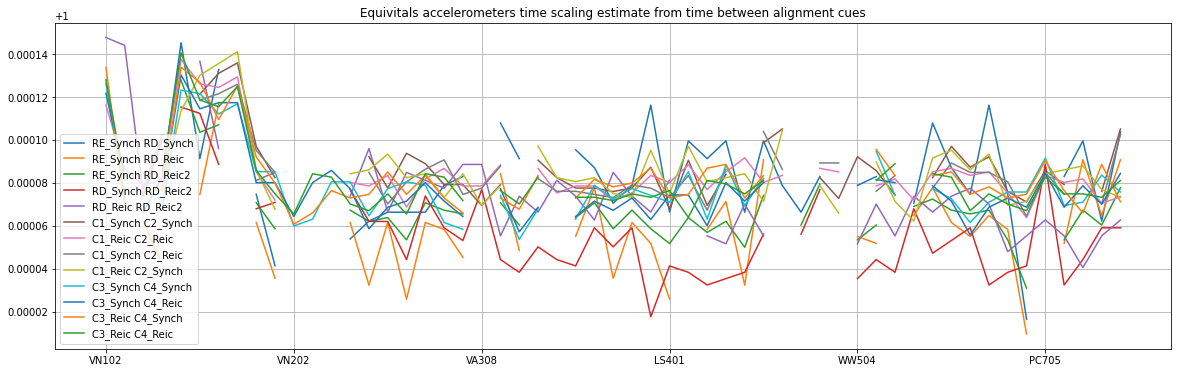

In [201]:
f, (ax) = plt.subplots(1, 1,figsize=(20,6))
longer_diffs = ['RE_Synch RD_Synch', 'RE_Synch RD_Reic', 'RE_Synch RD_Reic2','RD_Synch RD_Reic2', 'RD_Reic RD_Reic2','C1_Synch C2_Synch','C1_Reic C2_Reic','C1_Synch C2_Reic', 'C1_Reic C2_Synch','C3_Synch C4_Synch', 'C3_Synch C4_Reic', 'C3_Reic C4_Synch', 'C3_Reic C4_Reic',]
df_scales[longer_diffs ].plot(ax=ax)
plt.grid()
plt.title('Equivitals accelerometers time scaling estimate from time between alignment cues')

plt.savefig('./plots/EQ_scalingC_LongerD1D2.png', bbox_inches = 'tight',dpi = 300)
plt.show()

In [202]:
df_scales[longer_diffs ].median(axis=1).to_csv('EQ_scaling_default.csv')
df_scales[longer_diffs ].median(axis=1)

VN102    1.000129
VN107    1.000082
VN106    1.000074
VN108    1.000080
VN101    1.000130
VN105    1.000119
VN103    1.000117
VN104    1.000125
VN205    1.000085
VN203    1.000075
VN202    1.000063
VN206    1.000084
VN209    1.000082
VN210    1.000074
VN207    1.000067
VN208    1.000070
VN201    1.000072
VN204    1.000081
VA305    1.000073
VA307    1.000072
VA308    1.000077
VA301    1.000077
VA306    1.000060
VA302    1.000082
VA303    1.000079
VA304    1.000073
LS406    1.000078
LS407    1.000072
LS408    1.000075
LS405    1.000074
LS401    1.000073
LS403    1.000083
LS402    1.000067
LS410    1.000082
LS404    1.000070
WW505    1.000081
WW502    1.000086
WW503    1.000060
WW506    1.000082
WW501    1.000079
WW504    1.000054
WW507    1.000081
BR604    1.000077
BR603    1.000069
BR602    1.000079
BR606    1.000083
BR607    1.000075
BR605    1.000075
BR601    1.000073
PC704    1.000064
PC705    1.000085
PC703    1.000075
PC701    1.000075
PC702    1.000070
PC707    1.000078
dtype: flo

In [203]:
df_scales[longer_diffs ].median(axis=1).median()

1.0000772175375712

# plot the effectiveness of this scaling on signal alignment

In [207]:
Show_folder = {
    'RG':'../Data/Equivital/Aligned/20230215_RG/Full/',
    'RE':'../Data/Equivital/Aligned/20230215_RE/Full/',
    'RD':'../Data/Equivital/Aligned/20230215_RD/Full/',
    'C1':'../Data/Equivital/Aligned/20230216_C1/Full/',
    'C2':'../Data/Equivital/Aligned/20230216_C2/Full/',
    'C3':'../Data/Equivital/Aligned/20230217_C3/Full/',
    'C4':'../Data/Equivital/Aligned/20230217_C4/Full/',
    'C5':'../Data/Equivital/Aligned/20230218_C5/Full/'}

In [206]:
Piece_timings = pd.read_csv('./Timing/ctimes.csv')
Piece_timings.iloc[[31,32],:] 
# use Strauss excerpt across pieces to demonstrate alignment quality across conditions
# 1. close to alignment point or far, 
# 2. recording specific estimate of drift or device median

,Event,RD,C1,C2,C3,C4,C5
31,Strauss,3188.606,3628.738,138.478,84.507,3373.438,3441.964
32,Applause for Strauss,3334.334,3749.508,259.002,209.167,3493.683,3564.004


In [211]:
player_order

Index(['VN102', 'VN107', 'VN106', 'VN108', 'VN101', 'VN105', 'VN103', 'VN104',
       'VN205', 'VN203', 'VN202', 'VN206', 'VN209', 'VN210', 'VN207', 'VN208',
       'VN201', 'VN204', 'VA305', 'VA307', 'VA308', 'VA301', 'VA306', 'VA302',
       'VA303', 'VA304', 'LS406', 'LS407', 'LS408', 'LS405', 'LS401', 'LS403',
       'LS402', 'LS410', 'LS404', 'WW505', 'WW502', 'WW503', 'WW506', 'WW501',
       'WW504', 'WW507', 'BR604', 'BR603', 'BR602', 'BR606', 'BR607', 'BR605',
       'BR601', 'PC704', 'PC705', 'PC703', 'PC701', 'PC702', 'PC707'],
      dtype='object')

In [240]:
Performances = {}
piece_name = 'StraussStart'
datafile_type = 'EQBACC'
sigName = 'QoM'
# player_order
for concert in Piece_timings.columns[1:]:
    print(concert)
    data_loc = Show_folder[concert]
    files = os.listdir(data_loc)
    files.sort()
    sig_files = {}
    for f in files: 
        if f.endswith(datafile_type+'.csv'): 
            partID = f.split('_')[2]
            sig_files[partID] = data_loc+f
            
    sf = 50 # hz 
    s_time = Piece_timings.loc[31,concert]-5
    e_time =  Piece_timings.loc[31,concert]+25
    dur = e_time - s_time
    time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
    df_seg = pd.DataFrame(index = time_s, columns = player_order)
    
    df_sig = pd.DataFrame(index = time_s,columns = player_order,dtype='float') # Piece_timings.loc[2,ev]
    # ACC
    for partID in sig_files.keys(): #['c_sTime']
        V = pd.read_csv(sig_files[partID])
        sig_t = V['c_sTime']
        if sigName == 'QoM':
            sig_v = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))
        else:
            if sigName in V.columns:
                sig_v = V[sigName].values

        f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
        new_sig = f(time_s)
        df_sig.loc[:,partID] = new_sig
        
    Performances[concert] = df_sig.copy()

RD
C1
C2
C3
C4
C5


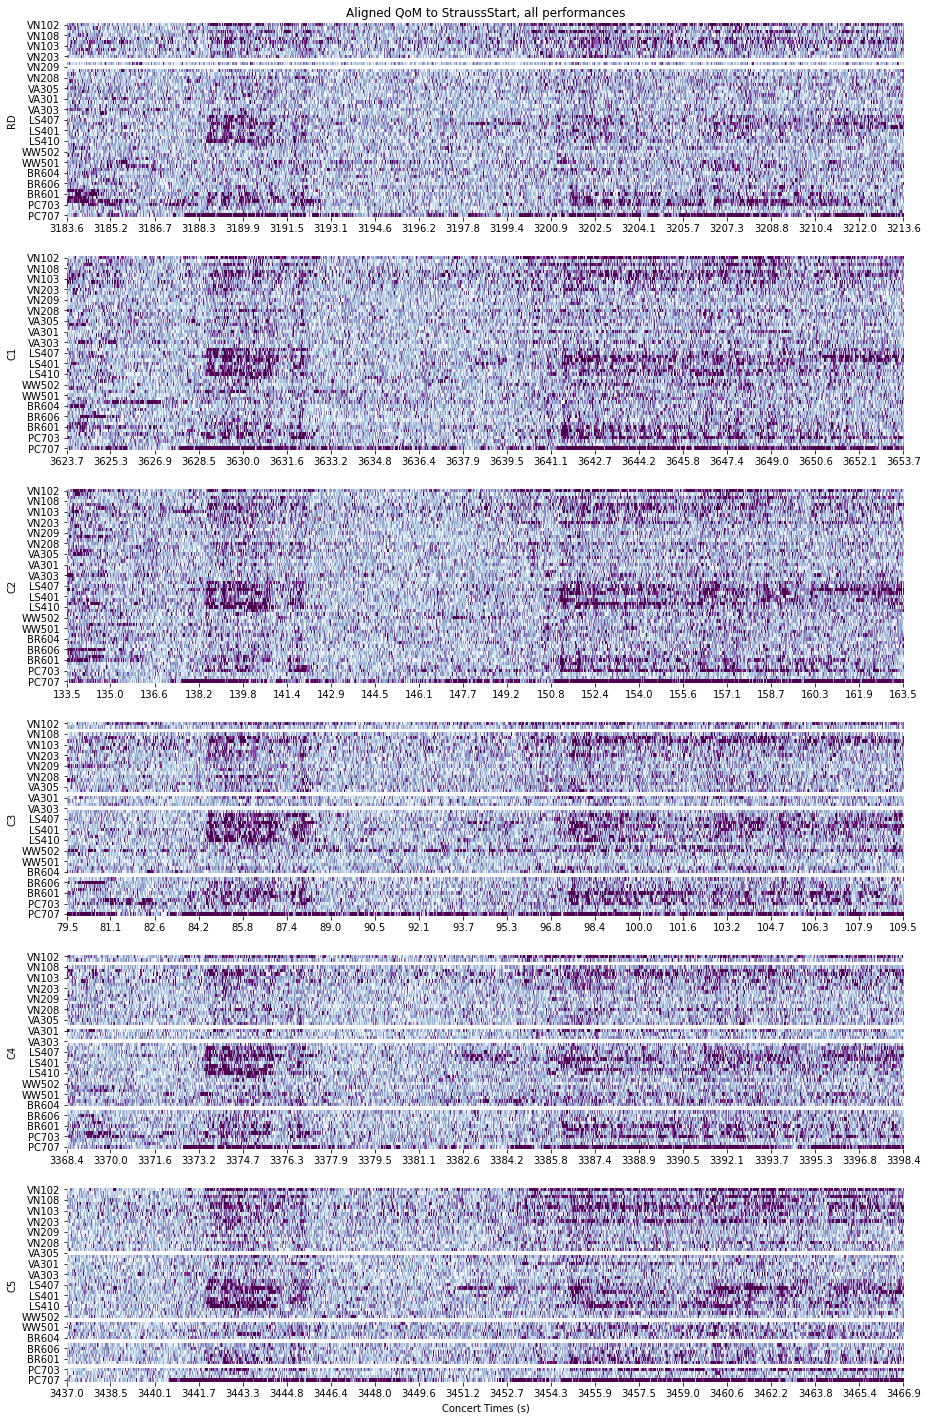

In [247]:
concerts = list(Performances.keys())
fig, (ax) = plt.subplots(len(concerts), 1,figsize = [15,25])
for i in range(len(concerts)):
    concert = concerts[i]
    df_sig = Performances[concert].copy()
    times = df_sig.index
    num_ticks = 20
    xticks = np.linspace(0, len(times) - 1, num_ticks, dtype='int')
    xticklabels = [np.round(times[idx],1) for idx in xticks]

    chart = sns.heatmap(data=df_sig.transpose(), ax=ax[i],vmin=5, vmax=25, cbar=False,cmap="BuPu")
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xticklabels,rotation = 0)
    ax[i].set_ylabel(concert)
    if i == 0:
        ax[i].set_title('Aligned ' +  sigName + ' to ' + piece_name + ', all performances')

ax[i].set_xlabel('Concert Times (s)')
plt.savefig('./plots/All_performances_'+ piece_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()
